In [1]:
## This program demonstrates a useful way to compare species presence/absence data to physical variables like 
## temperature and salinity. In this case, the species presence/absence data comes from passive acoustic monitoring 
## (PAM) detections of a specific type of dolphin vocalization. The seawater temperature and salinity are measured at 
## the same location. (Both the hydrophone and the CTD are on a mooring at the bottom of the ocean at a depth of
## 230m off Cape Hatteras, NC.) 

## The approach is to look at the probability density function (PDF) of the physical variable (in this case, water 
## temperature) for the duration of the period of observation. Then, we look at the PDF of the same physical variable 
## WHEN the species was detected. (Doing so, requires interpolating the temperature time series to the sample times 
## when the species was detected.) A Kolmogorov-Smirnoff (KS) Test is then applied to show that these two distributions 
## are statistically different.

## On the other hand, if we apply a GAM to the data, it fails to show a relationship between the detections and the 
## temperature/salinity. So, one should not always just throw the data into a GAM to see if there's a relationship.    


## libs
install.packages("pracma")
library("pracma")          # for interp1
library("stats")           # for ks.test
library("mgcv")            # for gam


Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Loading required package: nlme
This is mgcv 1.8-24. For overview type 'help("mgcv-package")'.

Attaching package: ‘mgcv’

The following object is masked from ‘package:pracma’:

    magic



In [2]:
## Read csv files
# ctd
ctd <- read.csv(file="ctd_CSI2.csv", header=FALSE, sep=",")
# detections
detections <- read.csv(file="detections_CSI2.txt", header=FALSE, sep=",")


In [3]:
## Convert ctd to arrays with correct data type
## Time from a format like 2016-10-27T07:00:00
ctd_timestamp = as.POSIXct(strptime(ctd[,1],'%Y-%m-%dT%H:%M:%S'))
ctd_sample_interval <- difftime(ctd_timestamp[2],ctd_timestamp[1],units='mins')
ctd_sample_interval
# T,S
salinity <- ctd[,3]
temperature <- ctd[,2]

## Convert detections to array with correct data type
## Time from a format like 2016-10-27T07:00:00
detections_timestamp = as.POSIXct(strptime(detections[,1],'%Y-%m-%dT%H:%M:%S'))
detections_sample_interval <- difftime(detections_timestamp[2],detections_timestamp[1],units='mins')
detections_sample_interval


Time difference of 9.983333 mins

Time difference of 180 mins

In [4]:
## Interpolate to the more sparse detections_timestamp, forming temperature_i, salinity_i
## First convert timestamp to numeric
ctd_timestamp_numeric <- as.numeric(ctd_timestamp)
detections_timestamp_numeric <- as.numeric(detections_timestamp)
temperature_i <- interp1(ctd_timestamp_numeric, temperature, detections_timestamp_numeric, method = "linear")
salinity_i <- interp1(ctd_timestamp_numeric, salinity, detections_timestamp_numeric, method = "linear")
ctd_sample_interval_numeric<-ctd_timestamp_numeric[2]-ctd_timestamp_numeric[1]


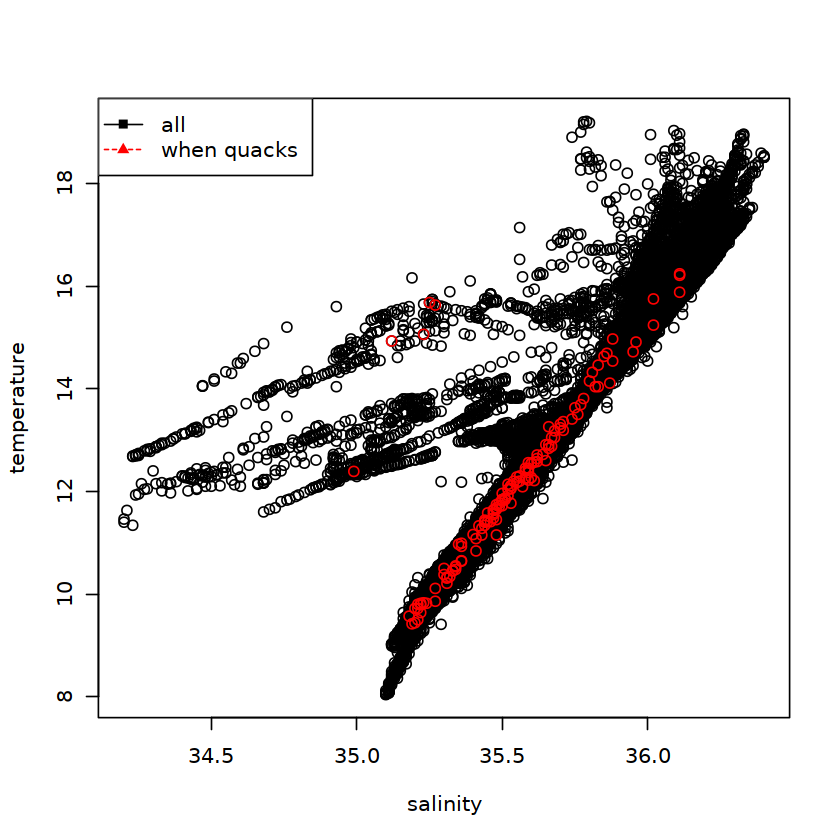

In [5]:
## Plot TS as well as interpolated TS
plot(salinity, temperature,type="p", col="black")
points(salinity_i, temperature_i, col="red")
legend( x="topleft",
        legend=c("all","when quacks"),
        col=c("black","red"), lwd=1, lty=c(1,2), 
        pch=c(15,17) )


In [6]:
## PDF of both temperature and temperature_i, using same color-coding as in the TS plot.
## Set T_hist_mids, so it's the sme for both histograms
## Acquire density for T,S
T_hist_mids <- hist(temperature, breaks=12, plot=FALSE)$mids
T_hist_density <- hist(temperature, breaks=12, plot=FALSE)$density
## Acquire density for Ti,Si
Ti_hist_mids <- hist(temperature_i, breaks=12, plot=FALSE)$mids
Ti_hist_density <- hist(temperature_i, breaks=12, plot=FALSE)$density
## Determine ranges for first plot, so second plot will fit.
xrange<-range(c(T_hist_mids, Ti_hist_mids))
yrange<-range(c(T_hist_density, Ti_hist_density))


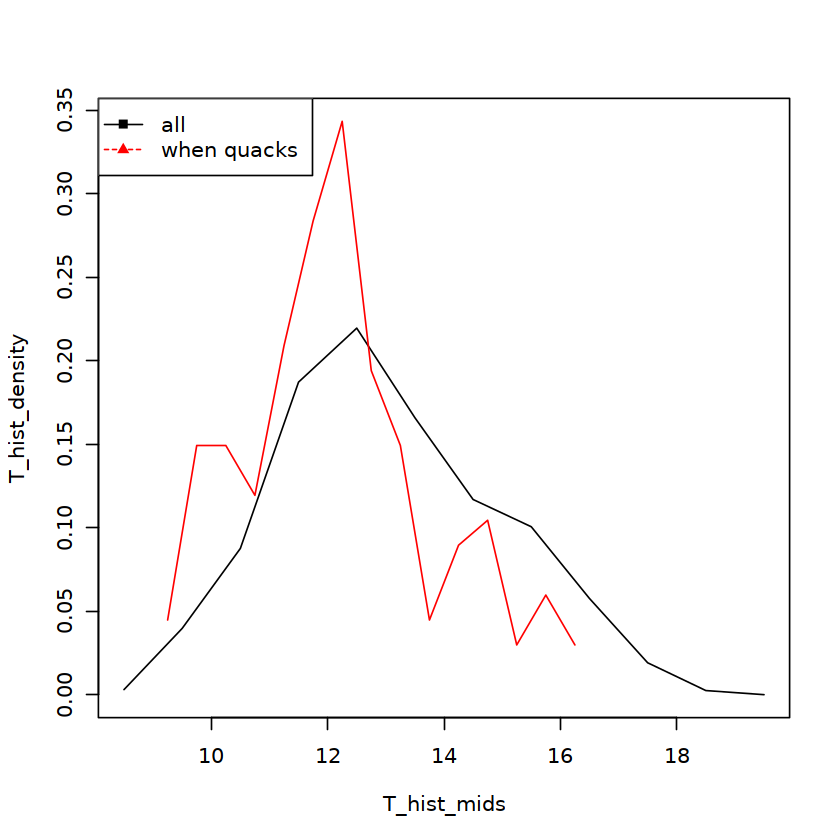

In [7]:
## Plot PDFs
plot.new()
plot(T_hist_mids,T_hist_density,type="l", xlim=xrange, ylim=yrange, col="black")
lines(Ti_hist_mids,Ti_hist_density,col="red")
legend( x="topleft",
        legend=c("all","when quacks"),
        col=c("black","red"), lwd=1, lty=c(1,2), 
        pch=c(15,17) )


In [8]:
## Are these two PDFs the same distribution, or are they statistically different distributions? 
## If the p-value is low, the distributions are statistically different
pvalue <- ks.test(temperature, temperature_i)$p.value
pvalue


Warning message in ks.test(temperature, temperature_i):
“p-value will be approximate in the presence of ties”

[1] 8.824742e-07

In [ ]:
## Now, let's compare this KS-based approach to a GAM.
##
## Instead of interpolating the physical variable to the biological, we'll do it the other way around,
## So, for each temperature sample, we'll have another variable representing species presence/absence.
## Initialize presence to zero
num_samples_ctd<-length(temperature)
presence<-matrix(0,num_samples_ctd,1)
## For each detection, find the closest CTD sample. Then, set its corresponding presence value to 1.
num_samples_detections<-length(detections_timestamp)
detection_sample_num<-1
for (j in 1:num_samples_ctd)
{
  if (abs(ctd_timestamp_numeric[j]-detections_timestamp_numeric[detection_sample_num]) < ctd_sample_interval_numeric ) {
    ## This CTD timestamp is near a detection, so set presence to 1 and increment detection_sample_num
    presence[j]=1.0
    detection_sample_num<-detection_sample_num+1    
  }
  if (detection_sample_num > num_samples_detections) break
}

## Verify the presence indicator time series 
##plot.new()
##plot(ctd_timestamp_numeric, presence,type="p", col="black")


In [10]:
## Try gam
gam1 = gam(presence ~ s(temperature) + s(salinity),family=binomial)
summary(gam1)


Family: binomial 
Link function: logit 

Formula:
presence ~ s(temperature) + s(salinity)

Parametric coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -6.2862     0.1031  -60.97   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                 edf Ref.df Chi.sq p-value
s(temperature) 1.017  1.028  0.001   0.986
s(salinity)    2.339  3.039  6.334   0.100

R-sq.(adj) =  0.000502   Deviance explained = 1.99%
UBRE = -0.96932  Scale est. = 1         n = 61276

In [11]:
## We see that R-squared and "Deviance explained" are very low. Therefore, in this case, a GAM fails to uncover a relationship 
## between the biological presence/absence indicator (detections) and the physical variable (temperature). Yet, the
## KS-test did show that the distribution of temperatures WHEN vocalizations were heard is different than the 
## distribution of all temperature values in the dataset.